# **FDA Food Event: Soft Drink/Water**

# **I. Introduction and Dataset Description**


As one of the most commonly consumed products, soft drinks/water products have far-reaching effects beyond simple weight gain. In severe cases, consumption can lead to hospitalization, disability, or even life-threatening consequences. To better understand these risks, we leverage the openFDA Food, Dietary Supplements, and Cosmetic Adverse Event API, which provides data from the Center for Food Safety and Applied Nutrition's Adverse Event Reporting System (CAERS). This database contains information on adverse event and product complaint reports submitted to the FDA from 2004 to 2025-02-16.

Our goal is to explore various product types within the soft drink and water industry, identify vulnerable groups (such as age and gender), and analyze the reactions, severity of impact, and correlation of symptoms associated with these products.

# **II. Data Acquisition**

In this section, we use openFDA's Food API to examine adverse events linked to FDA-regulated foods, specifically Soft Drink/Water industry. Due to API constraints, the maximum value for the limit parameter is set at 1000. Therefore, we retrieve the data in chunks to gather a comprehensive dataset for analysis with for-loop. For each iteration, an API request is made, resulting in a total of 3476 data records.

In [ ]:
from urllib.request import urlopen
import pandas as pd
import json

data_list = []
for i in range(0, 4000, 1000):
  url = f"https://api.fda.gov/food/event.json?search=products.industry_name:%22Soft+Drink/Water%22&skip={i}&limit=1000"
  response = urlopen(url)
  data_json = json.loads(response.read())
  data_list.extend(data_json["results"])

with open("data/raw_fda_soft_drink_data.json", "w") as file:
    json.dump(data_list, file, indent=4)

print("Data has been saved to raw_fda_soft_drink_data.json")

Data has been saved to raw_fda_soft_drink_data.json


In [ ]:
df = pd.DataFrame(data_list)
print("Size of the DataFrame:", df.shape)
df.head()

Size of the DataFrame: (3476, 7)


,report_number,outcomes,date_created,reactions,date_started,consumer,products
0,93655,"[Required Intervention, Other Serious or Impor...",20070613,"[ANXIETY, ASTHENIA, CONVULSION, DEPRESSION, FA...",20070320,"{'age': '17', 'age_unit': 'year(s)', 'gender':...","[{'role': 'SUSPECT', 'name_brand': 'DIET COKE ..."
1,114770,[Other Outcome],20081021,[VOMITING],20081020,{'gender': 'Female'},"[{'role': 'SUSPECT', 'name_brand': 'DASANI PUR..."
2,153453,"[Visited Emergency Room, Visited a Health Care...",20120613,"[DYSPHAGIA, FATIGUE, INFECTION, LOCAL SWELLING...",20120422,{'gender': 'Female'},"[{'role': 'SUSPECT', 'name_brand': 'XXX VITAMI..."
3,194667,"[Visited Emergency Room, Visited a Health Care...",20151007,"[ABDOMINAL PAIN, ABDOMINAL PAIN UPPER, APPETIT...",None,{'gender': 'Male'},"[{'role': 'SUSPECT', 'name_brand': 'FAMILY GOU..."
4,108237,[Visited Emergency Room],20081124,"[ANAPHYLACTIC SHOCK, DYSPNOEA]",20080703,{'gender': 'Male'},"[{'role': 'SUSPECT', 'name_brand': 'NIAGRA WAT..."


# **III. Data Cleaning and Handling Inconsistencies**

In this section, we will:

*  **Fix Incorrect Data Formats:** We will convert dates from strings to datetime format.
*  **Correct Nested Data:** The consumer and product columns contain nested dictionaries. We will separate these into individual columns for easier access.
*  **Handle List Columns:** The outcomes and reactions columns contain lists of items. We will create dummy variables for each item in the lists for more effective analysis.
*  **Remove Missing Values:** Rows with missing or null values will be removed.
*  **Eliminate Duplicate Rows:** We will remove any duplicate rows to ensure the dataset contains only unique records.
*  **Standardize Text Data:** All alphabetic characters will be converted to lowercase to maintain uniformity.
*  **Convert String to Numeric:** The age column, which is stored as a string, will be converted into a numeric format for analysis.



In [ ]:
import numpy as np

# Ensure Proper Datetime Formatting
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y%m%d', errors='coerce')
df['date_started'] = pd.to_datetime(df['date_started'], format='%Y%m%d', errors='coerce')

# Normalize the 'consumer' column
consumer_df = pd.json_normalize(df['consumer'])
df = pd.concat([df.drop(columns=['consumer']), consumer_df], axis=1)

# Separate the 'role' and 'name_brand' from the 'products' column
df['product_role'] = df['products'].apply(lambda x: x[0]['role'] if isinstance(x, list) and len(x) > 0 else None)
df['product_name_brand'] = df['products'].apply(lambda x: x[0]['name_brand'].lower() if isinstance(x, list) and len(x) > 0 and isinstance(x[0].get('name_brand'), str) else None)

df.drop(columns=['products'], inplace=True)

# Drop report_number column, product_role and age_unit column since they are not necessary for further analysis
df.drop(columns=['report_number'], inplace=True)
df.drop(columns=['age_unit'], inplace=True)
df.drop(columns=['product_role'], inplace=True)

# Since data are in list format, flatten the data
df['outcomes'] = df['outcomes'].apply(lambda x: x if isinstance(x, list) else [x]) \
                             .explode() \
                             .apply(lambda x: x.lower() if isinstance(x, str) else x) \
                             .reset_index(drop=True)

df['reactions'] = df['reactions'].apply(lambda x: x if isinstance(x, list) else [x]) \
                                 .explode() \
                                 .apply(lambda x: x.lower() if isinstance(x, str) else x) \
                                 .reset_index(drop=True)

# Create dummy variables for the 'outcomes' column
outcomes_dummies = pd.get_dummies(df['outcomes'], prefix='outcome')

# Create dummy variables for the 'reactions' column
reactions_dummies = pd.get_dummies(df['reactions'], prefix='reaction')

df = pd.concat([df, outcomes_dummies, reactions_dummies], axis=1)

# Remove missing values
df = df.dropna()

# Drop duplicates
df = df.drop_duplicates()

# Convert age from string to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Reset the index for dataframe
df = df.reset_index(drop=True)

print("Size of the cleaned DataFrame:", df.shape)

df.to_csv("data/cleaned_fda_soft_drink_data.csv", index=False)

print("Cleaned data has been saved to cleaned_fda_soft_drink_data.csv")

Size of the cleaned DataFrame: (1020, 530)
Cleaned data has been saved to cleaned_fda_soft_drink_data.csv


In [ ]:
df.head()

,outcomes,date_created,reactions,date_started,age,gender,product_name_brand,outcome_allergic reaction,outcome_congenital anomaly,outcome_death,...,reaction_visual acuity reduced,reaction_visual disturbance,reaction_visual impairment,reaction_vitamin b6 increased,reaction_vitreous floaters,reaction_vomiting,reaction_weight decreased,reaction_weight increased,reaction_wheezing,reaction_white blood cell count increased
0,required intervention,2007-06-13,anxiety,2007-03-20,17.0,Female,diet coke soda,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,visited emergency room,2004-03-26,insomnia,2004-02-18,8.0,Female,"archer farms market xl cooler, orange pineapple",False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,other outcome,2007-02-20,obsessive-compulsive disorder,2007-02-16,52.0,Female,sobe lean diet mango melon beverage,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,other outcome,2015-06-24,restlessness,2015-06-09,4.0,Male,acadia spring water,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,visited a health care provider,2018-10-13,pain,2018-10-05,44.0,Male,mt. dew,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# **IV. Exploratory Data Analysis:**


We now expore the dataset by:
* Generate summary statistics and descriptive insights
* Visualize distributions, relationships, and trends
* Identify patterns, correlations, and anomalies
* Provide initial interpretations of data insights


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dummy_col = df.columns[df.columns.str.startswith("reaction_")].tolist()
dummy_col.extend(df.columns[df.columns.str.startswith("outcome_")].tolist())
print(dummy_col)

for i in df:
  if i in dummy_col:
    df[i] = df[i].astype(int)

['reaction_abasia', 'reaction_abdominal discomfort', 'reaction_abdominal distension', 'reaction_abdominal hernia', 'reaction_abdominal pain', 'reaction_abdominal pain lower', 'reaction_abdominal pain upper', 'reaction_abdominal tenderness', 'reaction_abnormal behaviour', 'reaction_accidental exposure to product', 'reaction_acne', 'reaction_acute myocardial infarction', 'reaction_adverse event', 'reaction_adverse reaction', 'reaction_aeromonas test positive', 'reaction_ageusia', 'reaction_agitation', 'reaction_alopecia', 'reaction_amnesia', 'reaction_amyotrophic lateral sclerosis', 'reaction_anaemia', 'reaction_anaphylactic reaction', 'reaction_anaphylactic shock', 'reaction_anger', 'reaction_anorexia', 'reaction_anosmia', 'reaction_anxiety', 'reaction_aphonia', 'reaction_aphthous stomatitis', 'reaction_apparent death', 'reaction_appetite disorder', 'reaction_arrhythmia', 'reaction_arthralgia', 'reaction_asthenia', 'reaction_asthma', 'reaction_atelectasis', 'reaction_atrial fibrillation

**Data Summary:**

In [ ]:
summary = df.describe(include='all')
summary

,outcomes,date_created,reactions,date_started,age,gender,product_name_brand,outcome_allergic reaction,outcome_congenital anomaly,outcome_death,...,reaction_visual acuity reduced,reaction_visual disturbance,reaction_visual impairment,reaction_vitamin b6 increased,reaction_vitreous floaters,reaction_vomiting,reaction_weight decreased,reaction_weight increased,reaction_wheezing,reaction_white blood cell count increased
count,1020,1020,1020,1020,1020.000000,1020,1020,1020.000000,1020.000000,1020.000000,...,1020.000000,1020.000000,1020.000000,1020.000000,1020.0,1020.000000,1020.000000,1020.000000,1020.000000,1020.0
unique,12,NaN,253,NaN,NaN,4,763,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,other outcome,NaN,diarrhoea,NaN,NaN,Female,diet coke,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,390,NaN,86,NaN,NaN,563,35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2015-07-11 00:55:03.529411840,NaN,2015-01-07 16:38:07.058823680,38.423549,NaN,NaN,0.000980,0.000980,0.004902,...,0.001961,0.002941,0.000980,0.000980,0.0,0.082353,0.001961,0.000980,0.000980,0.0
min,NaN,2003-05-07 00:00:00,NaN,1959-07-28 00:00:00,1.000000,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,NaN,2009-11-27 06:00:00,NaN,2009-05-24 12:00:00,24.000000,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,NaN,2016-03-29 00:00:00,NaN,2015-11-24 12:00:00,40.000000,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
75%,NaN,2021-02-25 18:00:00,NaN,2020-09-10 00:00:00,53.000000,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
max,NaN,2024-07-27 00:00:00,NaN,2024-07-26 00:00:00,90.000000,NaN,NaN,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0


From last summary table, we find some descriptive insights:


1. **Data Overview**: The dataset contains **1,020 records** and **530 features**, including timestamps, categorical variables, and one-hot encoded `reaction_` and `outcome_` variables.  

2. **Time Coverage**: Most records are from **2010 onward**, but `date_started` has an outlier of 1959.

3. **Demographics**: **Median age is 38.42 years**, with cases ranging from **1 to 90 years** (possible outliers). **Female cases are the most common(563 occurrences)**.  

4. **Product Insights**: The dataset includes **763 unique brands**, with `diet coke` appearing most frequently (35 times).  

5. **Common Reactions**: `diarrhoea` is the most frequently reported reaction (86 cases), while `reaction_vomiting` occurs relatively often (mean = 0.082).  

6. **Severe Outcomes**: **Death is recorded in 0.5% of cases**, and **allergic reactions occur in 0.1%**, indicating some high-risk cases in the dataset.  



**Age Group Distribution:**

<ipython-input-45-75b5295b9b6a>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
<ipython-input-45-75b5295b9b6a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age_group', order=labels, palette="viridis")


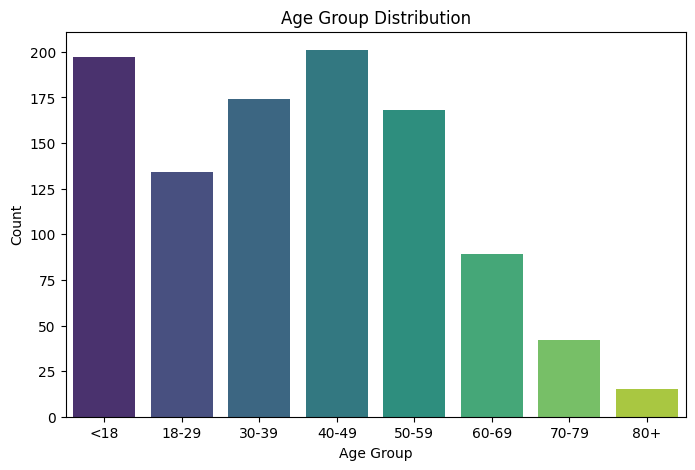

<Figure size 640x480 with 0 Axes>

In [ ]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')

bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='age_group', order=labels, palette="viridis")
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()
plt.savefig('EDA_figures/age_group_distribution.png')

It is easily found that:

*   The distribution of the population is mainly concentrated in the two intervals of <18 and 40-49.
*   It declines sharply after the age of 50-59 years.




**Anomaly analysis:**

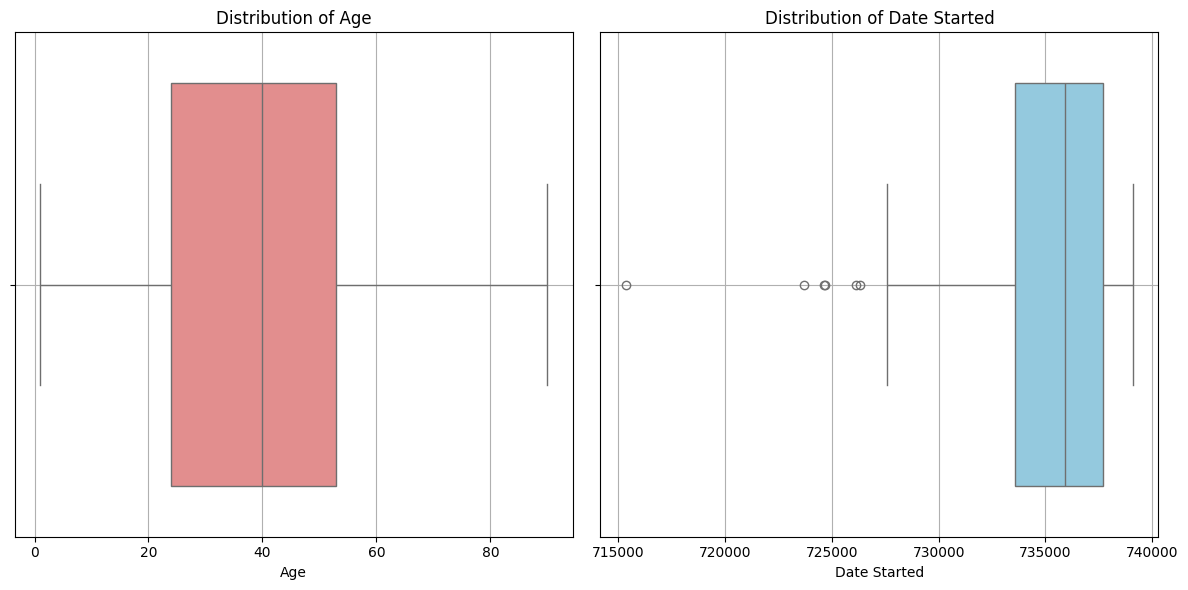

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))

# Create subplots
plt.subplot(1, 2, 1)
sns.boxplot(x=df['age'], color="lightcoral")
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=df['date_started'].map(pd.Timestamp.toordinal), color="skyblue")
plt.title("Distribution of Date Started")
plt.xlabel("Date Started")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
plt.savefig('EDA_figures/distribution_age_and_date_started.png')

**Initial Insights from Boxplots:**

1, Age Distribution:

*   Most cases are from adults (20-60 years old).
*   Some outliers exist, including very young (0 years) and very old (80+ years) cases.


2, Date Started Distribution:

*   Most reports are from 2000 onwards, with a peak around 2010-2020.

*   few very old cases (1960s-1990s) may be historical records or data errors.






**Top 10 reported Brands:**

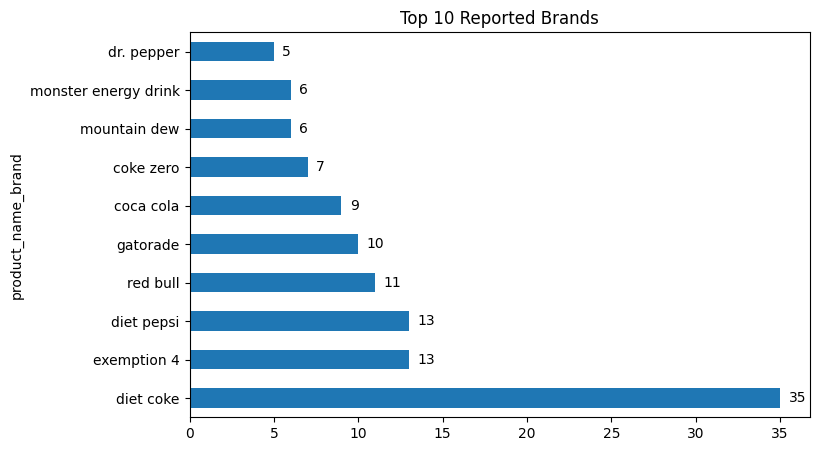

<Figure size 640x480 with 0 Axes>

In [ ]:
Top10_food = df['product_name_brand'].value_counts().head(10)

plt.figure(figsize=(8,5))
top10_foodp = Top10_food.plot(kind='barh', title="Top 10 Reported Brands")
for index, value in enumerate(Top10_food):
    top10_foodp.text(value + 0.5, index, str(int(value)), va='center')
plt.show()
plt.savefig('EDA_figures/top_10_reported_brands.png')

Diet Coke is showing a faulty lead.

<ipython-input-48-fd6b3c252be7>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['year_created'] = df['date_created'].dt.year


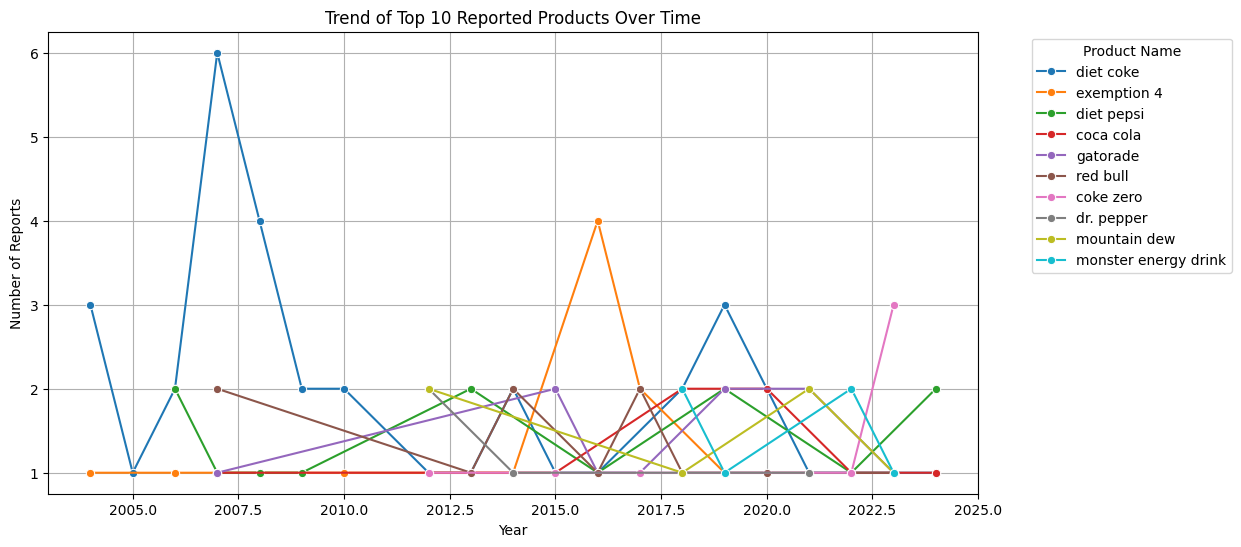

<Figure size 640x480 with 0 Axes>

In [ ]:
df['year_created'] = df['date_created'].dt.year
product_trend = df.groupby(['year_created', 'product_name_brand']).size().reset_index(name='count')
top_products = df['product_name_brand'].value_counts().nlargest(10).index

product_trend_filtered = product_trend[product_trend['product_name_brand'].isin(top_products)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=product_trend_filtered, x='year_created', y='count', hue='product_name_brand', marker="o")

plt.title("Trend of Top 10 Reported Products Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.legend(title="Product Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
plt.savefig('EDA_figures/trend_top_10_reported_products_over_time.png')

With the exception of heavy fluctuation of Diet Coke and Exemption 4, the rest brands are basically stable between 0 and 2 across years

**Top 10 Reactions:**

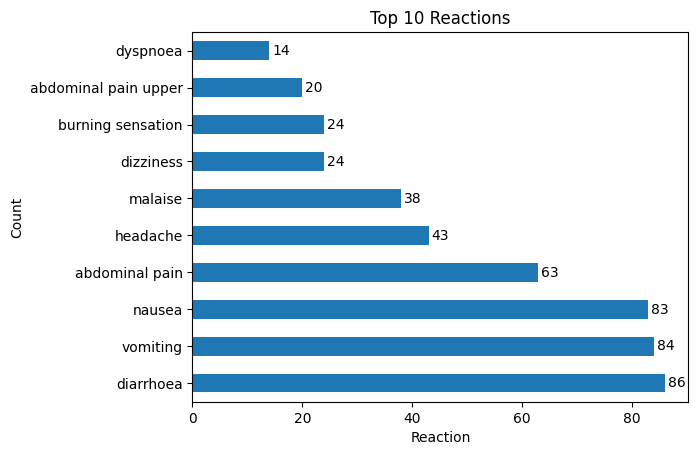

<Figure size 640x480 with 0 Axes>

In [ ]:
top10_r = df['reactions'].value_counts().head(10)
top10_r.index = top10_r.index.str.replace('reaction_', '', regex=True)
top10_rp = top10_r.plot(kind='barh', title="Top 10 Reactions")
plt.xlabel('Reaction')
plt.ylabel('Count')
for index, value in enumerate(top10_r):
    top10_rp.text(value + 0.5, index, str(int(value)), va='center')

plt.show()
plt.savefig('EDA_figures/top_10_reactions.png')

We found that nausea, vomiting, and diarrhoea are the most common reactions.

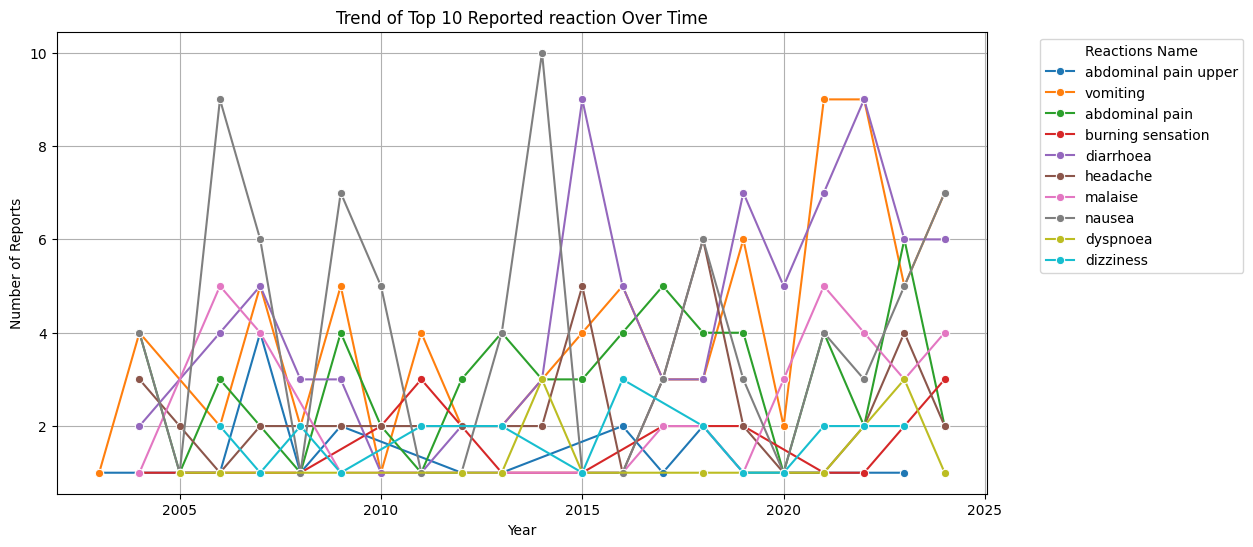

<Figure size 640x480 with 0 Axes>

In [ ]:
reaction_trend = df.groupby(['year_created', 'reactions']).size().reset_index(name='count')
top_reaction = df['reactions'].value_counts().nlargest(10).index

reaction_trend_filtered = reaction_trend[reaction_trend['reactions'].isin(top_reaction)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=reaction_trend_filtered, x='year_created', y='count', hue='reactions', marker="o")

plt.title("Trend of Top 10 Reported reaction Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.legend(title="Reactions Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
plt.savefig('EDA_figures/trend_top_10_reported_reaction_over_time.png')

With the exception of heavy fluctuation of nausea, diarrhoea, and vomiting, the rest reactions are basically stable between 0 and 4 across years.

**Health Outcomes Distribution:**

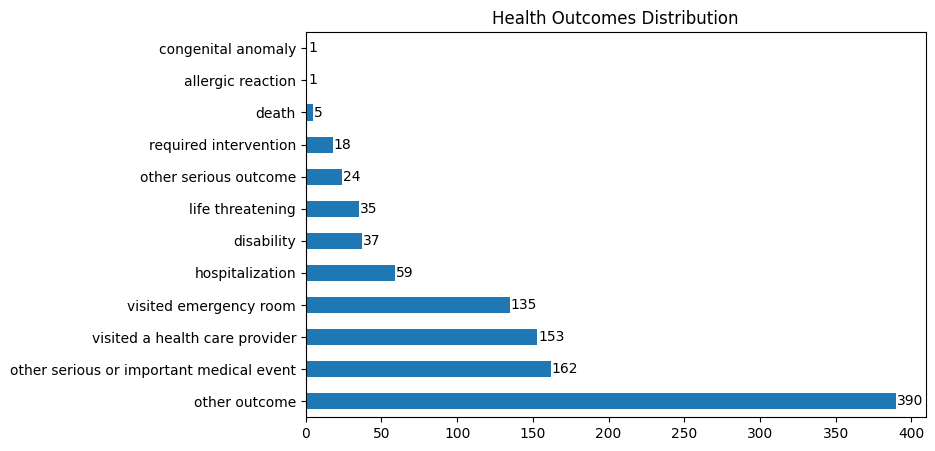

<Figure size 640x480 with 0 Axes>

In [ ]:
outcome_cols = [col for col in df.columns if 'outcome_' in col]
outcome_counts = df[outcome_cols].sum().sort_values(ascending=False)
outcome_counts.index = outcome_counts.index.str.replace('outcome_', '', regex=True)
plt.figure(figsize=(8,5))
outcome_countsp = outcome_counts.plot(kind='barh', title="Health Outcomes Distribution")
for index, value in enumerate(outcome_counts):
    outcome_countsp.text(value + 0.5, index, str(int(value)), va='center')
plt.show()
plt.savefig('EDA_figures/health_outcomes_distribution.png')

From the bar chart of above, the least frequent outcomes include "congenital anomaly" and "allergic reaction," each with only 1 occurrence.



**Correlation Analysis:**

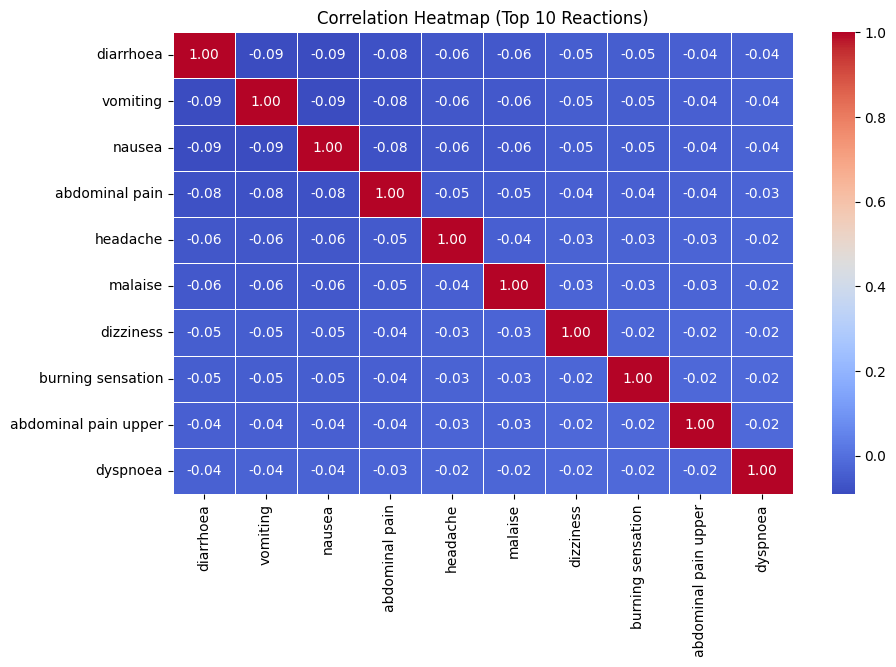

<Figure size 640x480 with 0 Axes>

In [ ]:
reaction_cols = [col for col in df.columns if 'reaction_' in col]
reaction_counts = df[reaction_cols].sum().sort_values(ascending=True)
top_10_reactions = reaction_counts.sort_values(ascending=False).head(10).index
top10_columns = list(top_10_reactions)
correlation_subset = df[top10_columns].corr()

clean_reactions = [col.replace('reaction_', '') for col in top_10_reactions]
correlation_subset.index = clean_reactions
correlation_subset.columns = clean_reactions

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Top 10 Reactions)")
plt.show()
plt.savefig('EDA_figures/correlation_heatmap_top_10_reactions.png')


This heatmap shows that the absence of concurrent symptoms was demonstrated.

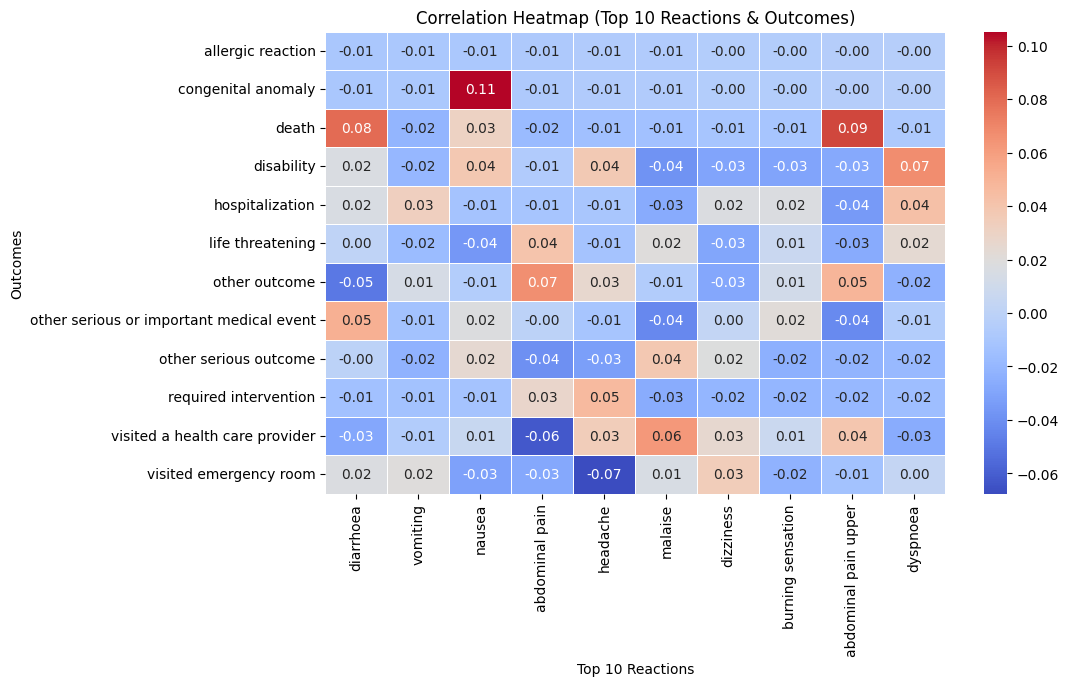

<Figure size 640x480 with 0 Axes>

In [ ]:
selected_columns2 = list(top_10_reactions) + outcome_cols
correlation_subset2 = df[selected_columns2].corr()

correlation_subset_reformatted = correlation_subset2.loc[outcome_cols, top_10_reactions]

clean_outcomes = [col.replace('outcome_', '') for col in outcome_cols]

correlation_subset_reformatted.index = clean_outcomes
correlation_subset_reformatted.columns = clean_reactions

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_subset_reformatted, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Top 10 Reactions & Outcomes)")
plt.xlabel("Top 10 Reactions")
plt.ylabel("Outcomes")
plt.show()
plt.savefig('EDA_figures/correlation_heatmap_top_10_reactions_outcomes.png')

Obvious relationship between congenital anomaly and nausea is shown, also combined with some other significant relation such as death and abdominal pain upper, we could make further research on them.

**Relationship Between Age and Gender Distribution:**

<ipython-input-54-4ba6ef7d94bf>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="age vs gender")


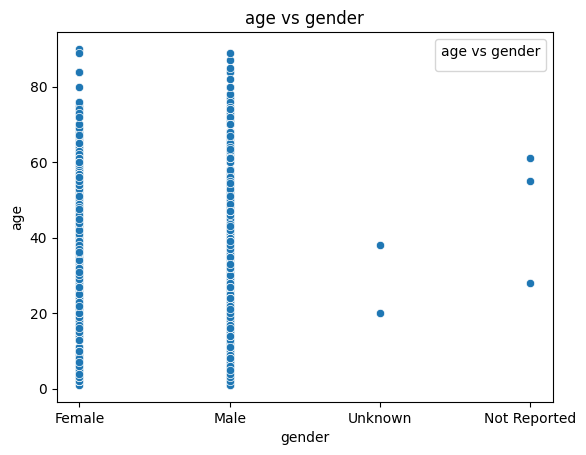

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.scatterplot(data=df, x='gender', y='age')
plt.title("age vs gender")
plt.xlabel("gender")
plt.ylabel("age")
plt.legend(title="age vs gender")
plt.show()
plt.savefig('EDA_figures/age_vs_gender.png')

The age distribution of male and female is a little different. There are more higher aged male than female.  Besides this, the age distribution of male is more even than female

**Time-based Feature Engineering**

In [ ]:
# Calculate time difference between report and incident
df['report_delay'] = (df['date_created'] - df['date_started']).dt.days

# Extract temporal features
df['report_year'] = df['date_created'].dt.year
df['report_month'] = df['date_created'].dt.month
df['report_weekday'] = df['date_created'].dt.weekday
df['report_quarter'] = df['date_created'].dt.quarter

# Create season feature
df['season'] = df['report_month'].map({
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
})

# Check time-based features
print("\nTime-based Features Summary:")
print("\nReport Delay Statistics:")
print(df['report_delay'].describe())
print("\nTemporal Distribution:")
print("Year distribution:", df['report_year'].value_counts().sort_index().head())
print("Season distribution:", df['season'].value_counts())


Time-based Features Summary:

Report Delay Statistics:
count     1020.000000
mean       184.345098
std       1068.350234
min         -4.000000
25%          2.000000
50%          6.000000
75%         26.000000
max      22391.000000
Name: report_delay, dtype: float64

Temporal Distribution:
Year distribution: report_year
2003     3
2004    38
2005    23
2006    48
2007    65
Name: count, dtype: int64
Season distribution: season
Spring    285
Summer    280
Winter    228
Fall      227
Name: count, dtype: int64


<ipython-input-87-aa7911eedc70>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['report_delay'] = (df['date_created'] - df['date_started']).dt.days
<ipython-input-87-aa7911eedc70>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['report_year'] = df['date_created'].dt.year
<ipython-input-87-aa7911eedc70>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

**Product Feature Engineering**

In [ ]:
# Extract product categories
def categorize_product(name):
    name = str(name).lower()
    if 'water' in name:
        return 'Water'
    elif any(x in name for x in ['energy', 'monster', 'red bull']):
        return 'Energy Drink'
    elif any(x in name for x in ['cola', 'pepsi', 'coke']):
        return 'Cola'
    elif 'gatorade' in name:
        return 'Sports Drink'
    else:
        return 'Other'

df['product_category'] = df['product_name_brand'].apply(categorize_product)

# Create brand feature
def extract_brand(name):
    name = str(name).lower()
    major_brands = ['coca-cola', 'pepsi', 'monster', 'gatorade', 'red bull',
                   'dasani', 'aquafina', 'poland spring']
    for brand in major_brands:
        if brand in name:
            return brand
    return 'other'

df['brand'] = df['product_name_brand'].apply(extract_brand)

# Check product features
print("\nProduct Features Summary:")
print("\nProduct Category Distribution:")
print(df['product_category'].value_counts())
print("\nBrand Distribution:")
print(df['brand'].value_counts())


Product Features Summary:

Product Category Distribution:
product_category
Other           403
Water           323
Cola            170
Energy Drink     78
Sports Drink     46
Name: count, dtype: int64

Brand Distribution:
brand
other            826
pepsi             47
gatorade          46
monster           26
poland spring     22
red bull          16
coca-cola         13
aquafina          12
dasani            12
Name: count, dtype: int64


<ipython-input-88-50e6e31ea299>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['product_category'] = df['product_name_brand'].apply(categorize_product)
<ipython-input-88-50e6e31ea299>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['brand'] = df['product_name_brand'].apply(extract_brand)


**Age Feature Engineering**

In [ ]:
# Create binary features for vulnerable age groups
df['is_minor'] = (df['age'] < 18).astype(int)
df['is_elderly'] = (df['age'] >= 65).astype(int)

# Check age features
print("\nAge Features Summary:")
print("\nAge Group Counts:")
print("Minors (< 18):", df['is_minor'].sum())
print("Elderly (>= 65):", df['is_elderly'].sum())
print("\nAge Statistics by Category:")
print(df.groupby('product_category')['age'].describe())


Age Features Summary:

Age Group Counts:
Minors (< 18): 197
Elderly (>= 65): 104

Age Statistics by Category:
                  count       mean        std   min    25%   50%    75%   max
product_category                                                             
Cola              170.0  41.806882  17.556928   5.0  28.55  43.0  54.00  90.0
Energy Drink       78.0  32.943462  13.438449  12.0  24.69  32.5  41.75  84.0
Other             403.0  36.331017  20.584822   1.0  20.00  38.0  51.00  89.0
Sports Drink       46.0  31.560870  18.588867   5.8  16.50  28.0  44.00  84.0
Water             323.0  41.554365  20.509124   1.0  27.00  44.0  56.00  89.0


<ipython-input-89-ff7da351de43>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_minor'] = (df['age'] < 18).astype(int)
<ipython-input-89-ff7da351de43>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_elderly'] = (df['age'] >= 65).astype(int)


**Reaction Severity Score**

In [ ]:
# Calculate reaction count
reaction_cols = [col for col in df.columns if col.startswith('reaction_')]
df['reaction_count'] = df[reaction_cols].sum(axis=1)

# Create severity score
outcome_cols = [col for col in df.columns if col.startswith('outcome_')]
outcome_weights = {
    'outcome_death': 5,
    'outcome_life threatening': 4,
    'outcome_hospitalization': 3,
    'outcome_disability': 3,
    'outcome_required intervention': 2,
    'outcome_visited emergency room': 2,
    'outcome_visited a health care provider': 1,
    'outcome_other outcome': 1
}

df['severity_score'] = sum(df[col] * weight
                          for col, weight in outcome_weights.items()
                          if col in df.columns)

# Check severity features
print("\nSeverity Features Summary:")
print("\nReaction Count Statistics:")
print(df['reaction_count'].describe())
print("\nSeverity Score Statistics:")
print(df['severity_score'].describe())
print("\nAverage Severity by Product Category:")
print(df.groupby('product_category')['severity_score'].mean().sort_values(ascending=False))


Severity Features Summary:

Reaction Count Statistics:
count    1020.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: reaction_count, dtype: float64

Severity Score Statistics:
count    1020.000000
mean        1.276471
std         1.011240
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: severity_score, dtype: float64

Average Severity by Product Category:
product_category
Energy Drink    1.435897
Sports Drink    1.326087
Water           1.281734
Cola            1.258824
Other           1.243176
Name: severity_score, dtype: float64


<ipython-input-90-1dcae1789d64>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['reaction_count'] = df[reaction_cols].sum(axis=1)
<ipython-input-90-1dcae1789d64>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['severity_score'] = sum(df[col] * weight


**Standardize Numerical Features**

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['age', 'reaction_count', 'severity_score', 'report_delay']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Check standardized features
print("\nStandardized Features Summary:")
for feature in numeric_features:
    print(f"\n{feature} statistics after standardization:")
    print(df[feature].describe())


Standardized Features Summary:

age statistics after standardization:
count    1.020000e+03
mean    -2.159493e-16
std      1.000491e+00
min     -1.892836e+00
25%     -7.295248e-01
50%      7.973489e-02
75%      7.372584e-01
max      2.608671e+00
Name: age, dtype: float64

reaction_count statistics after standardization:
count    1020.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: reaction_count, dtype: float64

severity_score statistics after standardization:
count    1.020000e+03
mean     8.533479e-17
std      1.000491e+00
min     -1.262902e+00
25%     -2.735318e-01
50%     -2.735318e-01
75%      7.158385e-01
max      3.683949e+00
Name: severity_score, dtype: float64

report_delay statistics after standardization:
count    1.020000e+03
mean     1.393221e-17
std      1.000491e+00
min     -1.763818e-01
25%     -1.707629e-01
50%     -1.670169e-01
75%     -1.482873e-01
max      2.079613e+01
Name: report_delay, dtype

**Encode Categorical Variables**

In [ ]:
categorical_features = ['season', 'product_category', 'brand', 'gender']
df_encoded = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features)

# Check encoded features
print("\nEncoded Features Summary:")
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
print("\nNew encoded columns (sample):")
print(df_encoded.columns[-20:])  # Show last 20 columns as sample


Encoded Features Summary:

Original shape: (1020, 544)
Encoded shape: (1020, 562)

New encoded columns (sample):
Index(['season_Summer', 'season_Winter', 'product_category_Cola',
       'product_category_Energy Drink', 'product_category_Other',
       'product_category_Sports Drink', 'product_category_Water',
       'brand_aquafina', 'brand_coca-cola', 'brand_dasani', 'brand_gatorade',
       'brand_monster', 'brand_other', 'brand_pepsi', 'brand_poland spring',
       'brand_red bull', 'gender_Female', 'gender_Male', 'gender_Not Reported',
       'gender_Unknown'],
      dtype='object')


**Create Interaction Features**

In [ ]:
df_encoded['age_severity'] = df_encoded['age'] * df_encoded['severity_score']
df_encoded['reactions_delay'] = df_encoded['reaction_count'] * df_encoded['report_delay']

# Check interaction features
print("\nInteraction Features Summary:")
print("\nAge-Severity Interaction Statistics:")
print(df_encoded['age_severity'].describe())
print("\nReactions-Delay Interaction Statistics:")
print(df_encoded['reactions_delay'].describe())

# Final dataset summary
print("\nFinal Dataset Summary:")
print("Final shape:", df_encoded.shape)
print("\nMemory usage:", df_encoded.memory_usage().sum() / 1024**2, "MB")
print("\nSample of final features:")
print(df_encoded.head())
df_encoded.to_csv("data/processed_fda_soft_drink_data.csv", index=False)


Interaction Features Summary:

Age-Severity Interaction Statistics:
count    1020.000000
mean       -0.000417
std         0.957292
min        -4.827819
25%        -0.312343
50%        -0.018573
75%         0.351732
max         5.666388
Name: age_severity, dtype: float64

Reactions-Delay Interaction Statistics:
count    1020.0
mean        0.0
std         0.0
min        -0.0
25%         0.0
50%        -0.0
75%         0.0
max        -0.0
Name: reactions_delay, dtype: float64

Final Dataset Summary:
Final shape: (1020, 564)

Memory usage: 4.213443756103516 MB

Sample of final features:
                         outcomes date_created                      reactions  \
0           required intervention   2007-06-13                        anxiety   
1          visited emergency room   2004-03-26                       insomnia   
2                   other outcome   2007-02-20  obsessive-compulsive disorder   
3                   other outcome   2015-06-24                   restlessness   
4  v

# **VI. Challenges faced and future recommendations**

**Challenges:**


*   While obtaining the data from the FDA, there is a constraint of 1,000 reports per request, so we came up with the idea of using a for-loop for multiple requests.


**Future Recommendations:**


*   It is important to note that products like Diet Coke, which result in the most adverse events, may not necessarily be dangerous because of the product itself. Instead, it could be because it is consumed more frequently than others, leading to more adverse events. Therefore, in the future, it might be worth considering the ratio of adverse events to the number of times a product is consumed.



# **VII. Each member’s contribution**


*   **Preach Apintanapong:** Preach is responsible for finding the data source from FDA, acquiring it using API requests, and performing data cleaning processes, as well as handling the GitHub repository.
*   **Liu Yang:** Liu is responsible for conducting exploratory data analysis (EDA), creating visualizations using tools like Matplotlib and Seaborn, identifying trends and anomalies in the data, and summarizing key insights to guide further analysis.
*   **Jingxi Li:**Jingxi is responseble for conducting exploratory data analysis, exploring the data by distribution and covariance analysis, as well as helping to optimize the API acquiring process.
*   **Yemin Wang:** Yemin is responsible for data preprocessing and feature engineering, including encoding catagorical variables and create new features













# **VIII. Link to your GitHub repository**
[https://github.com/ruangkawprc/AppliedDataScience_Project1](https://github.com/ruangkawprc/AppliedDataScience_Project1)